# TODO
- explore the increase/decrease in cosine similarity between each pairwise combination of tokens over the course of different sized embeddings. i predict groups statistically simple / quickly emergent groups like uppercase letters & vowels will have a decreasing trend, while less obvious relationships like those between the lowercase & uppercase version of a letter will have an increasing trend

#### !!!! DO NOT RUN THIS FIRST CELL UNLESS YOU HAVE THE SAME VENV PATH ISSUE THAT I DO

In [1]:
import sys
sys.path.append('/Users/tunadorable/local-repos/ng-video-lecture/venv/lib/python3.11/site-packages')

# Simple implementation of matryoshka embeddings into a GPT model

See my video guide [here]()

And the original paper [here](https://arxiv.org/abs/2205.13147) or a highlighted version in this same repo

### For now all of this code is just creating a simple GPT model, largely based on Andrej Karpathy's guide to minGPT from [this video](https://www.youtube.com/watch?v=kCc8FmEb1nY&t=5012s). The matryoshka embeeddings part will be further down

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import time
from typing import List
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [4]:
# hyperparameters
b = 4 # how many independent sequences will we process in parallel?
t = 16 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 50
lr = 3e-4 # learning rate for each backprop step
eval_iters = 20
h = 4 # number of attention heads
l = 4 # number of transormer layers
dropout = 0.2 # % of parameters to ignore every iteration
l2 = 0.01 # multiplier for our L2 norm to encourage sparsity

# embedding aka hidden dimension. this is the largest embedding size that the model will have
d = 32
# d should be a power of 2. power_of_d finds that power
power_of_d = int(math.log2(d))
# the smallest power of 2 we'll be considering as a matryoshka embedding
min_power = 3 # Starting from 2^min_power
# creating a list containing each power of 2 from min_power up to power_of_d
nesting_list = [2**i for i in range(min_power, int(power_of_d) + 1)]
print(nesting_list)

[8, 16, 32]


In [5]:
# the dataset is tinyshakespeare
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [6]:
# here are all the unique characters that occur in this text
# we'll be doing a character-wise tokenization for simplicity
chars = sorted(list(set(text)))
v = len(chars)
print(chars, v)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 65


In [7]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

In [8]:
# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest validation
train_data = data[:n]
val_data = data[n:]

In [9]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - t, (b,))
    x = torch.stack([data[i:i+t] for i in ix])
    y = torch.stack([data[i+1:i+t+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [10]:
# so you can see what the tokenized data looks like
x,y = get_batch('train')
print("x ", x.shape, "\n", x)
print("y ", y.shape, "\n", y)

x  torch.Size([4, 16]) 
 tensor([[44, 53, 59, 56,  1, 58, 46, 56, 43, 43, 57,  1, 53, 44,  1, 46],
        [56,  1, 40, 50, 53, 53, 42,  1, 58, 46, 53, 59,  1, 52, 43,  5],
        [51, 43, 11,  0, 21,  5, 50, 50,  1, 56, 59, 52,  1, 39, 61, 39],
        [43,  8,  0, 35, 46, 39, 58,  1, 57, 39, 63, 57,  1, 46, 43,  1]],
       device='mps:0')
y  torch.Size([4, 16]) 
 tensor([[53, 59, 56,  1, 58, 46, 56, 43, 43, 57,  1, 53, 44,  1, 46, 43],
        [ 1, 40, 50, 53, 53, 42,  1, 58, 46, 53, 59,  1, 52, 43,  5, 43],
        [43, 11,  0, 21,  5, 50, 50,  1, 56, 59, 52,  1, 39, 61, 39, 63],
        [ 8,  0, 35, 46, 39, 58,  1, 57, 39, 63, 57,  1, 46, 43,  1, 53]],
       device='mps:0')


In [11]:
@torch.no_grad()
# this evaluation function will be used later during training to see how well the model is doing
def estimate_loss():
    out = {}
    model.eval() # sets model to eval mode
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train() # just resets to training mode
    return out

In [12]:
class FeedFoward(nn.Module):
    """ a simple linear layer with a non-linearity """

    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 4 * d),
            nn.ReLU(),
            nn.Linear(4 * d, d),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [13]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(d, head_size, bias=False)
        self.query = nn.Linear(d, head_size, bias=False)
        self.value = nn.Linear(d, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(t, t))) # mask out future timestesps
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        b,t,d = x.shape
        k = self.key(x)   # (b,t,d/h)
        q = self.query(x) # (b,t,d/h)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (b, t, d/h) @ (b, d/h, t) -> (b, t, t)
        wei = wei.masked_fill(self.tril[:t, :t] == 0, float('-inf')) # (b, t, t)
        wei = F.softmax(wei, dim=-1) # (b, t, t)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (b,t,d/h)
        out = wei @ v # (b, t, t) @ (b, t, d/h) -> (b, t, d/h)
        return out

In [14]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention concatenated to work in parallel """

    def __init__(self, h, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(h)])
        self.proj = nn.Linear(head_size * h, d)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [15]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, d, h):
        # d: embedding dimension, h: the number of heads we'd like
        super().__init__()
        head_size = d // h # the double backslash just makes the output an int instead of float
        self.sa = MultiHeadAttention(h, head_size)
        self.ffwd = FeedFoward(d)
        self.ln = nn.LayerNorm(d, elementwise_affine=False)

    def forward(self, x):
        x = x + self.sa(self.ln(x))
        x = x + self.ffwd(self.ln(x))
        return x

# The Matryoshka Part

This first piece is the actual matryoshka loss function. It's essentially a framework on top of regular cross-entropy loss designed to simultaneously perform optimization pressure on different subsets of the embeddings. See the original paper for a better understanding

In [16]:
class Matryoshka_CE_Loss(nn.Module):
    '''
    Loss function for Matryoshka Representation Learning 
    '''
    def __init__(self, relative_importance: List[float]=None, **kwargs):
        super(Matryoshka_CE_Loss, self).__init__()
        self.criterion = nn.CrossEntropyLoss(**kwargs)
        
        # relative importance is a list of length g
        # this is optional for if you want to weight them differently
        # I've not messed around with this, but if you do i'd recommend having a lower weight on smaller vectors
        self.relative_importance = relative_importance

    def forward(self, logits, target):
        # logits are a tuple of length g containing tensors of shape [b batch size, t sequence length, v number of classes]
        g = len(logits)
        b,t,v = logits[-1].shape
        
        # target shape: [b batch size, t sequence length]

        # Calculate losses for each output and stack them together
        losses = torch.stack([self.criterion(logits_i.view(b*t, v), target.view(b*t)) for logits_i in logits])

        # Sets relative_importance to 1 unless specified otherwise
        rel_importance = torch.ones_like(losses) if self.relative_importance is None else torch.tensor(self.relative_importance)

        # Apply relative importance weights
        weighted_losses = rel_importance * losses
        
        return weighted_losses.sum()

#### This next piece is the actual output layer that maps the model's residual state to different sized headds that can fit into `Matryoshka_CE_Loss()`

In the original paper, they create a different linear mapping from the residual to each nesting doll head. As a second option, they provided the option to use one single matrix that would then be spliced, and called this the "efficiency" option. 

I've gone a step further; not only have I chosen the "efficiency" option, but I'm also using the actual embedding matrix as the output layer. This not only saves on parameters, but more importantly it allows this GPT model's embeddings to exhibit this matryoshka structure

In [17]:
class MRL_Linear_Layer(nn.Module):
    def __init__(self, nesting_list: List, num_classes=v, passed_in_layer=None, **kwargs):
        super(MRL_Linear_Layer, self).__init__()

        # the list of different dimension sizes for each nesting doll embedding
        self.nesting_list = nesting_list
        
        # Number of classes for classification, aka number of tokens in the vocabulary
        self.num_classes = num_classes  

        # presumably you'd be passing in the model's embedding matrix
        self.passed_in_layer = passed_in_layer

        # a conditional
        self.use_passed_in_layer = passed_in_layer is not None

        # if we didn't pass in the embedding matrix, then a shape (d,v) matrix would be automatically created
        # we do not end up using this, but it's there if you want to try it
        if not self.use_passed_in_layer:
            self.nesting_classifier_0 = nn.Linear(nesting_list[-1], self.num_classes, bias=False, device=device, **kwargs)
        
        # Initialize layer normalization
        self.layer_norm = nn.LayerNorm(nesting_list[-1], elementwise_affine=False)
        # we do elementwise_affine=False for interpretability reasons, which i'll explain later

    def forward(self, x):
        if self.use_passed_in_layer:
            # Apply layer normalization on the fly during the forward pass
            normed_passed_in_layer = self.layer_norm(self.passed_in_layer)

            # transpose the embedding matrix from (v,d) to (d,v) so that we can multiply against x which is (b,t,d)
            nesting_classifier_0 = normed_passed_in_layer.t().to(x.device)
        else:
            nesting_classifier_0 = self.nesting_classifier_0

        # so nesting_logits is a tuple which will hold tensors of sizes (b,t,d_i) where each d_i is a value in nesting_list
        nesting_logits = ()
        for i, num_feat in enumerate(self.nesting_list):
            nesting_logits += (torch.matmul(x[..., :num_feat], nesting_classifier_0[:num_feat, :]),)

        # so we're passing through a tuple length g of tensors shaped (b,t,v)
        return nesting_logits

### now here's the actual body of the model

In [18]:
class matryoshka_embeddings_GPT(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(v, d).to(device)
        
        # simple learned positional encodings rather than sine or RoPE
        self.position_embedding_table = nn.Embedding(t, d) 

        # bulk of the beast, the actual transformer blocks
        self.blocks = nn.Sequential(*[Block(d, h) for _ in range(l)]) 

        # a layer norm to use in a few places
        # again hopefully i'll remember to explain the elementwise_affine=False logic later
        self.ln = nn.LayerNorm(d, elementwise_affine=False) 
        
        ### MATRYOSHKA OUTPUT HEADS
        self.m_head = MRL_Linear_Layer(nesting_list = nesting_list, passed_in_layer = self.token_embedding_table.weight)
        
        ### MATRYOSHKA LOSS
        self.m_loss = Matryoshka_CE_Loss()
        
        # initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        b, t = idx.shape
        # idx and targets are both (b,t) tensor of integers

        # creating our first residual out of position and token embeddings
        pos_emb = self.position_embedding_table(torch.arange(t, device=device)) # (t,d)
        tok_emb = self.token_embedding_table(idx) # (b,t,d)
        x = self.ln(tok_emb) + pos_emb
        
        # the bulk of the actual transformer
        x = self.blocks(x) # (b,t,d) -> (b,t,d)
        x = self.ln(x) # (b,t,d) -> (b,t,d)

        # Matryoshka output head
        logits = self.m_head(x) # tensor [b,t,d] -> tuple ([b,t,d_0], [b,t,d_1], [b,t,d_2],..., [b,t,d_g])
        
        if targets is None:
            # if there's no target then that means we're doing inference not training, so no need for loss
            loss = None
        else:
            loss = self.m_loss(logits, targets) # length g tuple of tensors shape (b,t,d_i) & (b,t) -> float value

        return logits, loss

    def generate(self, idx, max_new_tokens, degree=power_of_d):
        # idx is (b, t) array of indices in the current context
        
        # so the degree determines which matryoshka embedding size we want to use for inference
        # remember each embedding is a power of 2 so degree is just that power
        # we default to power_of_d since that'd be using the full embedding, which should be the most accurate
        assert degree >= min_power & degree <= power_of_d
        
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -t:]
            
            # get the predictions
            logits, loss = self(idx_cond)
            
            # select the desired degree of matryoshka embedding
            logits = logits[degree-min_power]
            
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (b, d)
            
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (b, d)
            
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (b, 1)
            
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (b, t+1)
            
        return idx

In [19]:
model = matryoshka_embeddings_GPT().to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e3, 'K parameters')

52.512 K parameters


# IF you want to train your own version

In [ ]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=l2)

In [20]:
start_time = time.time()

# Enable anomaly detection
#torch.autograd.set_detect_anomaly(True)

for iter in range(max_iters):

    # sample a batch of data
    xb, yb = get_batch('train')
    
    # train
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        current_time = time.time()
        elapsed_time = current_time - start_time
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, time elapsed: {elapsed_time:.2f} seconds")

# Disable anomaly detection after the training loop
#torch.autograd.set_detect_anomaly(False)

step 0: train loss 52.3776, val loss 51.9756, time elapsed: 0.61 seconds
step 50: train loss 17.9597, val loss 19.1103, time elapsed: 7.06 seconds
step 100: train loss 12.1352, val loss 12.7248, time elapsed: 13.46 seconds
step 150: train loss 10.6458, val loss 11.0752, time elapsed: 19.83 seconds
step 200: train loss 10.5703, val loss 10.2126, time elapsed: 26.51 seconds
step 250: train loss 9.8705, val loss 9.8691, time elapsed: 33.31 seconds
step 300: train loss 9.6916, val loss 10.0804, time elapsed: 39.68 seconds
step 350: train loss 9.6676, val loss 9.8475, time elapsed: 45.93 seconds
step 400: train loss 9.5743, val loss 9.7923, time elapsed: 52.11 seconds
step 450: train loss 9.4802, val loss 9.4619, time elapsed: 58.30 seconds
step 500: train loss 9.4995, val loss 9.5318, time elapsed: 64.53 seconds
step 550: train loss 9.4441, val loss 9.4007, time elapsed: 70.74 seconds
step 600: train loss 9.3762, val loss 9.1913, time elapsed: 76.93 seconds
step 650: train loss 9.0615, val

In [21]:
## save the trained model
torch.save(model.state_dict(), f'models/{model.__class__.__name__}_b{b}_t{t}_d{d}_h{h}_l{l}_lr{lr}_drop{dropout}_l2-{l2}_min_power{min_power}_{time.strftime("%Y-%m-%d|%H-%M-%S")}.pth')

# Instead you can load a saved model

In [20]:
model = matryoshka_embeddings_GPT().to(device)  # Initialize a model with the same architecture

# Load the saved state dictionary
model.load_state_dict(torch.load('models/matryoshka_embeddings_GPT_b4_t16_d32_h4_l4_lr0.0003_drop0.2_l2-0.01_min_power3_2024-02-07|23-40-07.pth'))

# If you plan to continue training the model, switch to training mode
#model.train()

# If you only plan to do inference, switch to evaluation mode
model.eval()

matryoshka_embeddings_GPT(
  (token_embedding_table): Embedding(65, 32)
  (position_embedding_table): Embedding(16, 32)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=32, out_features=8, bias=False)
            (query): Linear(in_features=32, out_features=8, bias=False)
            (value): Linear(in_features=32, out_features=8, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=32, out_features=32, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=32, out_features=128, bias=True)
          (1): ReLU()
          (2): Linear(in_features=128, out_features=32, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln): LayerNorm((32,), eps=1e-05, elementwise_affine=False)
 

# Inference

In [21]:
input_str = "JULIET:\nO Romeo, Romeo! wherefore art thou R" # the classic line
context_tensor = torch.tensor([encode(input_str)], dtype=torch.long, device=device)

In [22]:
%%time
# seeing how well the smallest matryoshka embedding can do
# there's no real reason to do this other than curiosity since the compute it saves is negligible
output = model.generate(context_tensor, max_new_tokens=100, degree = min_power)
output_str = decode(output[0].tolist())
print(output_str)

JULIET:
O Romeo, Romeo! wherefore art thou RI
Tol:
Der, fotaavy t nr keroroletor!
Af silt bloe go icve be, heto torus or towo. y LO-:
Toor, noma
CPU times: user 1.49 s, sys: 101 ms, total: 1.6 s
Wall time: 1.66 s


In [23]:
%%time
# using the largest matryoshka embedding. this is a more realistic use-case
output = model.generate(context_tensor, max_new_tokens=100, degree = power_of_d)
output_str = decode(output[0].tolist())
print(output_str)

JULIET:
O Romeo, Romeo! wherefore art thou Ranglr.
 Y ckemayf Seancoiy fofos ba y aat w.



A: I USINORethe whet rerouave w.
NI s I GER: rour ba
CPU times: user 1.17 s, sys: 51.2 ms, total: 1.22 s
Wall time: 1.26 s


# analyzing token embedding vectors

here we'll explore what the embeddings look like by comparing different tokens to each other and different matryoshka subset sizes.

remember earlier how we were doing `elementwise_affine=False` on all of our layernorm modules? So "affine" is just another word for a linear transformation. What we were essentially doing there is making sure that our layernormed vectors were actually on a normal distribution rather than being messsed up by a linear layer.

this has important implications for interpretability. Basically, high dimensional vectors have this very weird quirk where if you layernorm them, then instead of thinking about vectors as being inside the volume of a sphere like in 3 dimensions, it's actually more accurate to think about all of them as existing right on the surface of the sphere. That is to say, layernormed vectors of sufficiently high dimension all have the same radius (within some negligible confidence interval). This is important because it means that we can compare the vectors using cosine similarity, which is a metric that only looks at the angle between vectors and completely ignores radius. Cosine similarity works because they all have the same radius, so no information is lost by only comparing angles

In [25]:
# Access the embedding weight matrix
embedding_matrix = model.token_embedding_table.weight.data

# If you want to look at the embedding for a specific token
token = 'a'
token_index = stoi[token]
token_embedding = embedding_matrix[token_index]

print(f"Embedding for token '{token}' index {token_index}: \n{token_embedding}")

Embedding for token 'a' index 39: 
tensor([-0.0150, -0.0153, -0.0280,  0.0118, -0.0210,  0.0366,  0.0417,  0.0315,
         0.0108,  0.0014, -0.0230,  0.0218, -0.0116,  0.0165,  0.0057, -0.0322,
         0.0191, -0.0129, -0.0463,  0.0003,  0.0158, -0.0151,  0.0360,  0.0307,
        -0.0196, -0.0228, -0.0063,  0.0303, -0.0284, -0.0180,  0.0395, -0.0051],
       device='mps:0')


In [26]:
def cosine_similarity(embedding1, embedding2):
    # Calculate the cosine similarity between two embeddings
    return F.cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0))

# Example tokens
token1 = 'a'
token2 = 'b'
token3 = 'i'
token4 = 'A'
token5 = '.'

# Convert tokens to indices
index1 = stoi[token1]
index2 = stoi[token2]
index3 = stoi[token3]
index4 = stoi[token4]
index5 = stoi[token5]

# Retrieve embeddings from the model
embedding1 = model.token_embedding_table.weight[index1]
embedding2 = model.token_embedding_table.weight[index2]
embedding3 = model.token_embedding_table.weight[index3]
embedding4 = model.token_embedding_table.weight[index4]
embedding5 = model.token_embedding_table.weight[index5]

# Calculate cosine similarity
for i, degree in enumerate(nesting_list):
    similarity = cosine_similarity(embedding1[:degree], embedding2[:degree])
    print(f"degree {degree} Cosine similarity between '{token1}' and '{token2}':", similarity.item())
print("\n\n")
for i, degree in enumerate(nesting_list):
    similarity = cosine_similarity(embedding1[:degree], embedding3[:degree])
    print(f"degree {degree} Cosine similarity between '{token1}' and '{token3}':", similarity.item())
print("\n\n")
for i, degree in enumerate(nesting_list):
    similarity = cosine_similarity(embedding1[:degree], embedding4[:degree])
    print(f"degree {degree} Cosine similarity between '{token1}' and '{token4}':", similarity.item())
print("\n\n")
for i, degree in enumerate(nesting_list):
    similarity = cosine_similarity(embedding1[:degree], embedding5[:degree])
    print(f"degree {degree} Cosine similarity between '{token1}' and '{token5}':", similarity.item())

degree 8 Cosine similarity between 'a' and 'b': 0.7380083799362183
degree 16 Cosine similarity between 'a' and 'b': 0.6913185715675354
degree 32 Cosine similarity between 'a' and 'b': 0.7627110481262207



degree 8 Cosine similarity between 'a' and 'i': 0.9248230457305908
degree 16 Cosine similarity between 'a' and 'i': 0.9212194085121155
degree 32 Cosine similarity between 'a' and 'i': 0.9210928678512573



degree 8 Cosine similarity between 'a' and 'A': -0.3936913013458252
degree 16 Cosine similarity between 'a' and 'A': -0.28839731216430664
degree 32 Cosine similarity between 'a' and 'A': 0.28431078791618347



degree 8 Cosine similarity between 'a' and '.': 0.1902138590812683
degree 16 Cosine similarity between 'a' and '.': 0.07545159757137299
degree 32 Cosine similarity between 'a' and '.': 0.2591727375984192


Notice how tokens 'a' and 'A' have increasing cosine similarity as the dimensionality increases. This is because the concept of a lowercase and a capital letter matching up is far more subtle relationship than something like the relationship between vowels, meaning that a model needs a larger embedding dimension and more time training in order to discover said relationship. In my experiments, it's usually around d=64 or d=128 where the model becomes extremely confident in the relationship between a capital and lowercase version of a letter. Meanwhile, models can figure out that vowels are related at somewhere aroudn d=4 to d=16, and models can tease out the difference between letters versus symbols at d=2

next we'll create a funciton to help us visualize cosine similarity at a larger scale

In [28]:
def plot_token_similarity(tokens, model, stoi, degree, nesting_list=nesting_list, size=6, save_path=None):
    # Initialize a matrix to store cosine similarities
    similarity_matrix = np.zeros((len(tokens), len(tokens)))

    degree = nesting_list[degree-min_power]
    
    # Calculate cosine similarity for each pair of tokens
    for i, token1 in enumerate(tokens):
        for j, token2 in enumerate(tokens):
            if i >= j:  # Only compute for lower triangle
                index1 = stoi[token1]
                index2 = stoi[token2]
                embedding1 = model.token_embedding_table.weight[index1]
                embedding2 = model.token_embedding_table.weight[index2]
                similarity = F.cosine_similarity(embedding1[:degree].unsqueeze(0), embedding2[:degree].unsqueeze(0))
                similarity_matrix[i, j] = similarity.item()
    
    # Mask the upper triangular part of the matrix
    mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))

    # Plotting
    fig, ax = plt.subplots(figsize=(size, size))
    # Use masked array to hide the upper triangle
    cax = ax.matshow(np.ma.masked_array(similarity_matrix, mask), cmap='viridis', vmin=-1, vmax=1)
    fig.colorbar(cax)

    # Set axis labels to the tokens
    ax.set_xticks(np.arange(len(tokens)))
    ax.set_yticks(np.arange(len(tokens)))
    ax.set_xticklabels(tokens)
    ax.set_yticklabels(tokens)
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labeltop=False)

    # Label axes
    ax.set_xlabel('Tokens')
    ax.set_ylabel('Tokens')
    ax.set_title(f'Cosine Sim bw Embeddings of degree {degree}')

    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    # Show the plot
    plt.show()


In [29]:
# reordering character tokens so that it more clearly shows some of the categories i expect to emerge
chars1 = ['\n', 
          '!','.','?', 
          ' ', '$', '&', "'", ',', '-', '3', ':', ';',
        'A', 'E', 'I', 'O', 'U', 
        'B', 'C', 'D', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y', 'Z',
        'a', 'e', 'i', 'o', 'u', 
        'b', 'c', 'd', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'v', 'w', 'x', 'y', 'z']

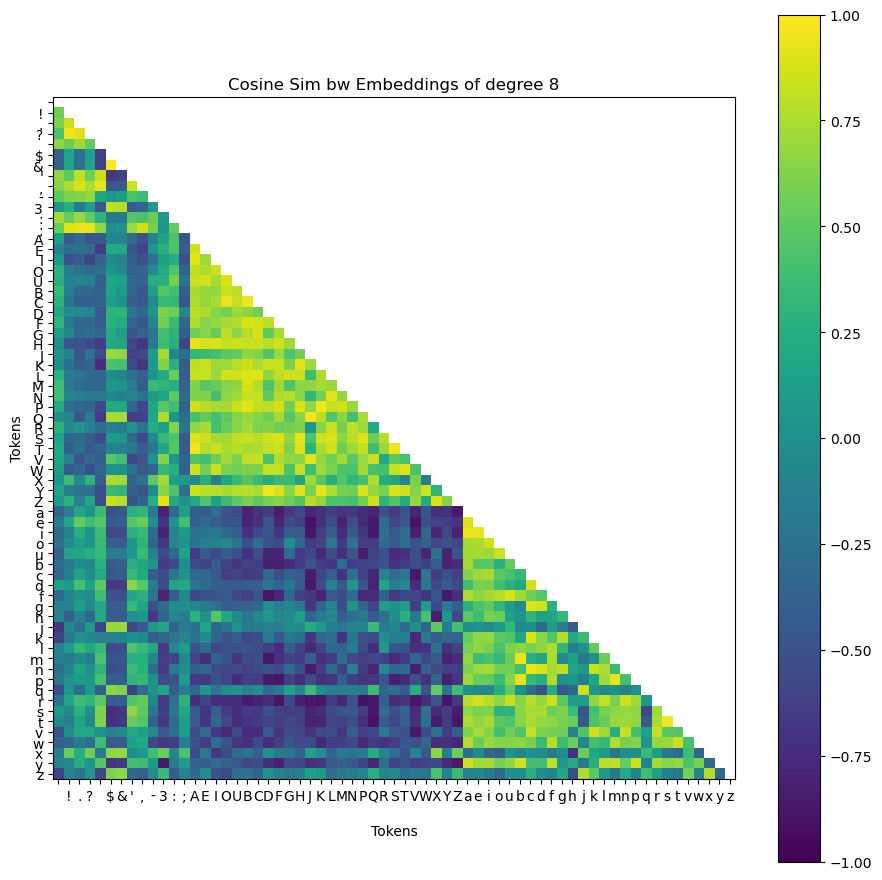

In [30]:
save_path = f'images/{model.__class__.__name__}_b{b}_t{t}_d{d}_h{h}_l{l}_lr{lr}_drop{dropout}_l2-{l2}_min_power{min_power}_{time.strftime("%Y-%m-%d|%H-%M-%S")}_degree{2**min_power}.png'
plot_token_similarity(chars1, model, stoi, degree=min_power, size=11, save_path=None)

see how the light versus dark areas allow us to see which tokens the model sees as related? here it can tell that symbols are a group, uppercase letters are a group, and lowercase letters are a group. furthermore, see how bright 'a' 'e' and 'i' are relative to each other, adn the same is true for '.' and '?', so the model seems to be developing the concept of what a vowel and an end of sentence symbol are

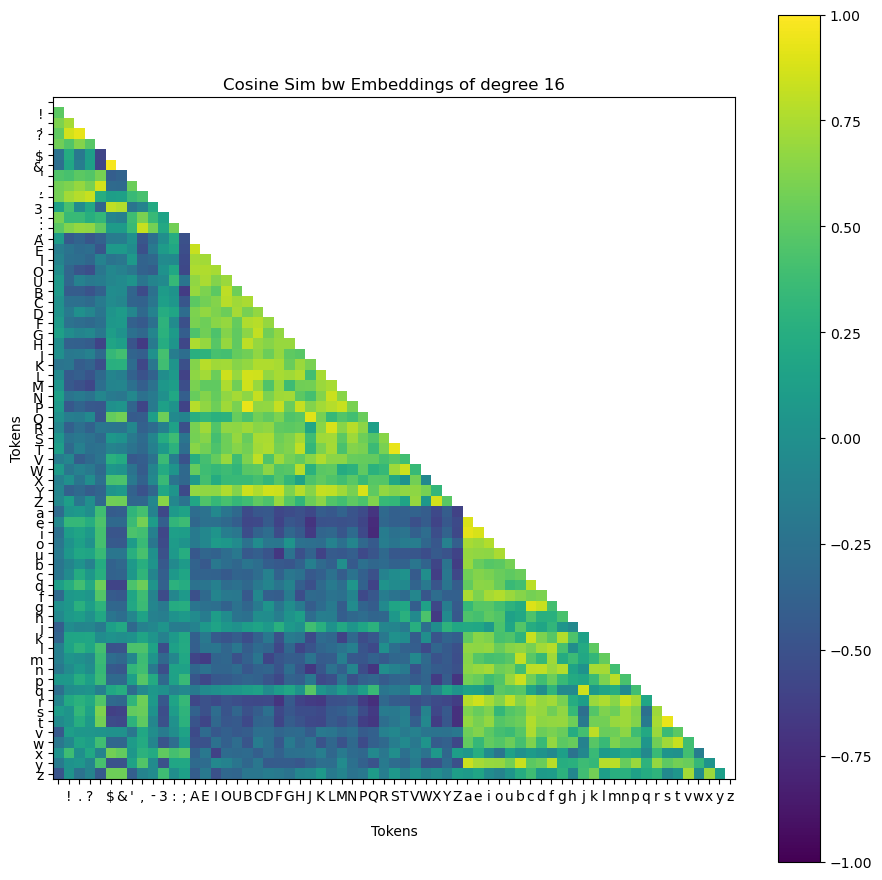

In [31]:
save_path = f'images/{model.__class__.__name__}_b{b}_t{t}_d{d}_h{h}_l{l}_lr{lr}_drop{dropout}_l2-{l2}_min_power{min_power}_{time.strftime("%Y-%m-%d|%H-%M-%S")}_degree{2**(power_of_d-1)}.png'
plot_token_similarity(chars1, model, stoi, degree=power_of_d-1, size=11, save_path=None)

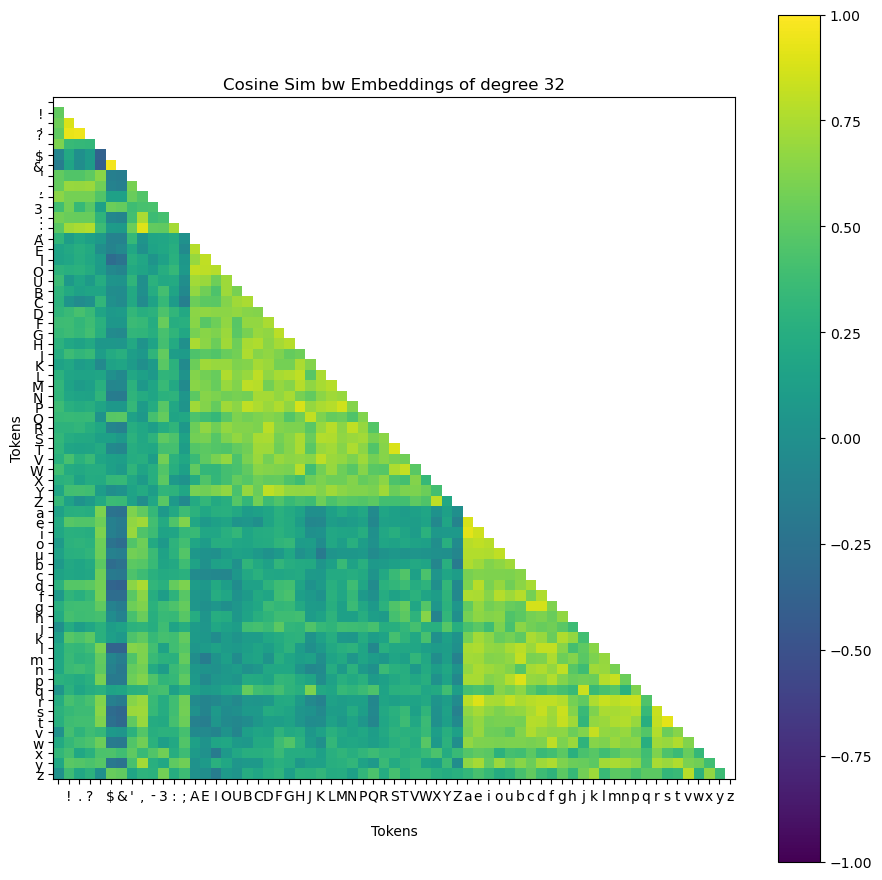

In [32]:
save_path = f'images/{model.__class__.__name__}_b{b}_t{t}_d{d}_h{h}_l{l}_lr{lr}_drop{dropout}_l2-{l2}_min_power{min_power}_{time.strftime("%Y-%m-%d|%H-%M-%S")}_degree{2**power_of_d}.png'
plot_token_similarity(chars1, model, stoi, degree=power_of_d, size=11, save_path=None)

# some extra useless stuff

In [ ]:
### old, works but doesn't layernorm the embedding matrix
### very odd is after i switched to the new one the loss went up by a lot. maybe i should look into that


class MRL_Linear_Layer(nn.Module):
    def __init__(self, nesting_list: List, num_classes=v, passed_in_layer=None, **kwargs):
        super(MRL_Linear_Layer, self).__init__()
        self.nesting_list = nesting_list
        self.num_classes = num_classes  # Number of classes for classification
        
        # we can pass in a size (v,d) layer (such as the embedding matrix)
        if passed_in_layer is None:
            self.nesting_classifier_0 = nn.Linear(nesting_list[-1], self.num_classes, bias=False, device=device, **kwargs)
        else:
            # Use the passed-in layer (embedding matrix) of shape (d,v) directly instead of creating a new learnable layer
            self.nesting_classifier_0 = passed_in_layer.to(device).t()
            
    def forward(self, x):
        nesting_logits = ()
        for i, num_feat in enumerate(self.nesting_list):
            nesting_logits += (torch.matmul(x[..., :num_feat], self.nesting_classifier_0[:num_feat,:]), )
        
        return nesting_logits
